RNN的实现

In [1]:
import numpy as np

In [2]:
class RNN:
    def __init__(self,Wx,Wh,b):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.cache=None  #对反向传播时需要用到的中间数据cache进行初始化
        
    def forward(self,x,h_prev): #下方的数据x和左侧前一个RNN层输入的h_prev
        Wx,Wh,b=self.params
        t=np.dot(h_prev,Wh) + np.dot(x,Wx) +b
        h_next=np.tanh(t)  #当前时刻RNN层的输出（下一时刻RNN层的输入）
        
        self.cache=(x,h_prev,h_next)
        return h_next
    
    def backward(self,dh_next):
        Wx,Wh,b=self.params
        x,h_prev,h_next=self.cache
        
        dt=dh_next * (1-h_next**2)
        db=np.sum(dt,axis=0)
        dWh=np.dot(h_prev.T,dt)
        dh_prev=np.dot(dt,Wh.T)
        dWx=np.dot(x.T,dt)
        dx=np.dot(dt,Wx.T)
        
        self.grads[0][...]=dWx
        self.grads[1][...]=dWh
        self.grads[2][...]=db
        
        return dx,dh_prev

Time RNN层的实现（TimeRNN由T个RNN层组合形成）

In [3]:
class TimeRNN:
    def __init__(self,Wx,Wh,b,stateful=False):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.layers=None
        
        self.h,self.dh=None,None  #h保存调用forward方法时最后一个RNN层隐藏状态，dh保存调用backward时传给前一个块的隐藏状态的梯度
        self.stateful=stateful
        
    def set_state(self,h):#设定隐藏状态
        self.h=h
    
    def reset_state(self):#重设隐藏状态
        self.h=None
    #隐藏状态为FALSE时，第一个RNN层被初始化为零矩阵
    
    def forward(self,xs):
        Wx,Wh,b=self.params
        N,T,D=xs.shape   #xs.shape=(N,T,D)   N是batch_size，T是时序数，D是数据维度，H是隐藏层大小
        D,H=Wx.shape
        #首次调用时RNN隐藏层状态h由所有元素均为0的矩阵初始化，在stateful为False下，h总被重置为零矩阵
        
        self.layers=[]
        hs=np.empty((N,T,H),dtype='f') #为输出准备一个容器
        
        if not self.stateful or self.h is None:
            self.h=np.zeros((N,H),dtype='f')
        
        for i in range(T):
            layer=RNN(*self.params)#创建一个小RNN块
            self.h=layer.forward(xs[:,t,:],self.h)  #计算RNN层各个时刻的隐藏状态，存在hs对应索引（时刻）中
            hs[:,t,:]=self.h  #保存每一层的输出状态
            self.layers.append(layer)  #保存每一层
            
        return hs
    
    def backward(self,dhs):
        Wx,Wh,b=self.params
        N,T,H=dhs.shape
        D,H=Wx.shape
        
        dxs=np.empty((N,T,D),dtype='f')
        dh=0
        grads=[0,0,0]
        for t in reversed(range(T)):
            layer=self.layers[t]
            dx,dh=layer.backward(dhs[:,t,:]+dh)#求和后的梯度
            dxs[:,t,:]=dx   #将x的梯度保存
            
            for i,grad in enumerate(layer.grads):  #保存每一个RNN层的梯度
                grads[i]+=grad
            
        for i,grad in enumerate(grads): #TRNN层最终的梯度是各个RNN层梯度之和
            self.grads[i][...]=grad #梯度求和覆盖
        
        self.dh=dh
        
        return dxs

处理时序数据的层的实现RNNLM

In [4]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRNNLM:
    def __init__(self,vocab_size,wordvec_size,hidden_size):
        V,D,H=vocab_size,wordvec_size,hidden_size
        rn=np.random.randn
        
        #初始化权重
        embed_W=(rn(V,D)/100).astype('f')
        rnn_Wx=(rn(D,H)/np.sqrt(D)).astype('f')
        rnn_Wh=(rn(H,H)/np.sqrt(H)).astype('f')
        rnn_b=np.zeros(H).astype('f')
        affine_W=(rn(H,V)/np.sqrt(H)).astype('f')
        affine_b=np.zeros(V).astype('f')
        
        #生成层
        self.layers=[
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx,rnn_Wh,rnn_b,stateful=True),
            TimeAffine(affine_W,affine_b)
        ]
        self.loss_layer=TimeSoftmaxWithLoss()
        self.rnn_layer=self.layers[1]
        
        #将所有权重和梯度整理到列表里
        self.params,self.grads=[],[]
        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads
            
    def forward(self,xs,ts):
        for layer in self.layers:
            xs=layer.forward(xs)
        loss=self.loss_layer.forward(xs,ts)
        return loss
    
    def backward(self,dout=1):
        dout=self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout=layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state

RNNLM的学习代码

In [7]:
import sys 
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb

#设定超参数
batch_size=10
wordvec_size=100
hidden_size=100  #RNN的隐藏状态向量的元素个数
time_size=5  #Truncated BPTT的时间跨度大小
lr=0.1
max_epoch=100

#读入训练数据（缩小的数据集）
corpus,word_to_id,id_to_word=ptb.load_data('train')
corpus_size=1000
corpus=corpus[:corpus_size]
vocab_size=int(max(corpus)+1)

xs=corpus[:-1]  #输入
ts=corpus[1:]  #输出（监督标签）
data_size=len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size,vocab_size))

#学习用的参数
max_iters=data_size // (batch_size*time_size)
time_idx=0
total_loss=0
loss_count=0
ppl_list=[]

#生成模型
model=SimpleRNNLM(vocab_size,wordvec_size,hidden_size)
optimizer=SGD(lr)

#计算读入mini-batch的各笔样本数据的开始位置, 数据须顺序读入，并且平移读入个数据的开始位置
jump=(corpus_size-1) // batch_size
offsets=[i* jump for i in range(batch_size)]  #偏移量，数据的开始位置

for epoch in range(max_epoch):
    for iter in range(max_iters):
        #获取mini-batch
        batch_x=np.empty((batch_size,time_size),dtype='i')  #初始化容器变量
        batch_t=np.empty((batch_size,time_size),dtype='i')
        for t in range(time_size):
            for i,offset in enumerate(offsets):
                batch_x[i,t]=xs[(offset+time_idx)%data_size]
                batch_t[i,t]=ts[(offset+time_idx)%data_size]
            time_idx+=1
        
        #计算题都，更新参数
        loss=model.forward(batch_x,batch_t)
        model.backward()
        optimizer.update(model.params,model.grads)
        total_loss+=loss
        loss_count+=1
        
    #各个epoch的困惑度评价
    ppl=np.exp(total_loss/loss_count)
    print("| epoch %d | perplexity %.2f" %(epoch+1,ppl))
    ppl_list.append(float(ppl))
    total_loss,loss_count =0,0

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 375.80
| epoch 2 | perplexity 246.81
| epoch 3 | perplexity 218.91
| epoch 4 | perplexity 212.23
| epoch 5 | perplexity 205.33
| epoch 6 | perplexity 202.43
| epoch 7 | perplexity 199.12
| epoch 8 | perplexity 196.14
| epoch 9 | perplexity 191.97
| epoch 10 | perplexity 192.99
| epoch 11 | perplexity 189.01
| epoch 12 | perplexity 192.64
| epoch 13 | perplexity 190.24
| epoch 14 | perplexity 191.19
| epoch 15 | perplexity 190.57
| epoch 16 | perplexity 187.50
| epoch 17 | perplexity 184.59
| epoch 18 | perplexity 181.25
| epoch 19 | perplexity 183.37
| epoch 20 | perplexity 184.42
| epoch 21 | perplexity 182.50
| epoch 22 | perplexity 178.20
| epoch 23 | perplexity 175.95
| epoch 24 | perplexity 177.13
| epoch 25 | perplexity 174.55
| epoch 26 | perplexity 174.16
| epoch 27 | perplexity 169.11
| epoch 28 | perplexity 168.08
| epoch 29 | perplexity 166.43
| epoch 30 | perplexity 160.79
| epoch 31 | perplexity 161.00
| epoch 

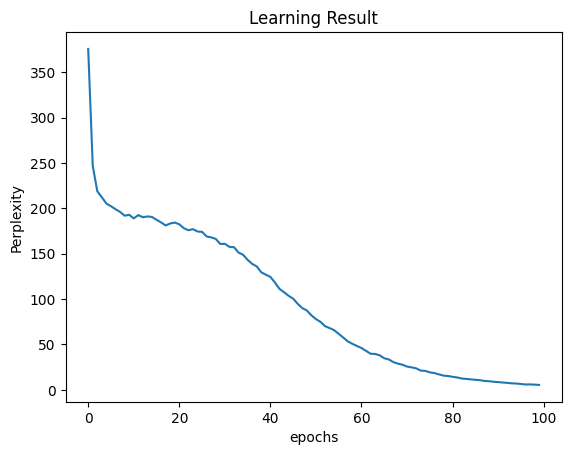

In [41]:
plt.title('Learning Result')
plt.xlabel('epochs')
plt.ylabel('Perplexity')
x=range(0,100,1)
plt.plot(x,ppl_list)
plt.show()